In [1]:
import os

from PIL import Image
import skimage.io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def psnr(original, decoded):
    mse = np.mean(np.power(original - decoded, 2))
    if(mse == 0):
        return np.inf
    max_val = 255.0
    psnr = 20 * np.log10(max_val / np.sqrt(mse))
    return psnr

In [3]:
model_name = "default"

my_coords = {}
jpg_coords = {}

filenames = ["lena", "baboon", "peppers"]

for filename in filenames:
    my_coords[filename] = []
    for B in [1, 2, 4, 6]:
        image_path = fr"compression-lab-imgs\{filename}.png"
        encode_output_path = fr"compression-lab-imgs\{filename}_B{B}.neural"
        compressor_state_path = fr"compression-lab-imgs\{filename}_B{B}_state.json"
        decode_output_path = fr"compression-lab-imgs\{filename}_decoder_output_B{B}.bmp"

        orig_img_np = skimage.io.imread(image_path)
        n_pixels = np.prod(orig_img_np.shape)

        !python encode.py -i {image_path} -B {B} -s {compressor_state_path} -o {encode_output_path} -m {model_name}
        !python decode.py -i {encode_output_path} -B {B} -s {compressor_state_path} -o {decode_output_path}  -m {model_name}

        my_img_np = skimage.io.imread(decode_output_path)
        my_psnr = psnr(orig_img_np, my_img_np)
        my_bpp = os.path.getsize(encode_output_path) / n_pixels
        my_coords[filename].append((my_bpp, my_psnr))


    jpg_coords[filename] = []
    orig_img = Image.fromarray(orig_img_np)    
    for jpg_quality in [30, 60, 70, 90]:
        jpg_path = fr"compression-lab-imgs\{filename}_q{jpg_quality}.jpg"
        orig_img.save(jpg_path, "JPEG", quality=jpg_quality, optimize=True, progressive=True)
        
        jpg_np = skimage.io.imread(jpg_path)
        jpg_psnr = psnr(orig_img_np, jpg_np)
        jpg_bpp = os.path.getsize(jpg_path) / n_pixels
        jpg_coords[filename].append((jpg_bpp, jpg_psnr))

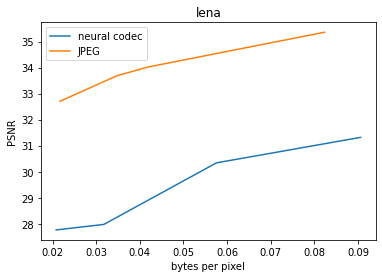

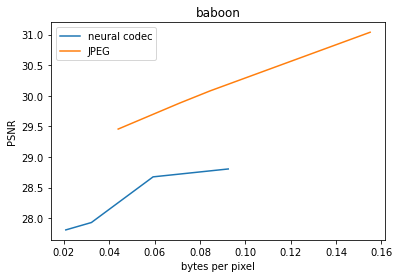

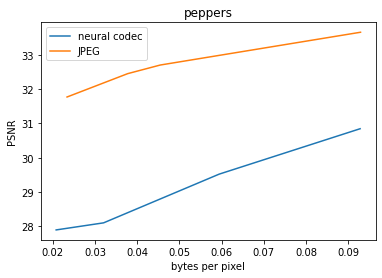

In [15]:
for filename in filenames:
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_title(filename)
    ax.set_xlabel('bytes per pixel')
    ax.set_ylabel('PSNR')
    plt.plot(*list(zip(*my_coords[filename])))
    plt.plot(*list(zip(*jpg_coords[filename])))
    ax.legend(["neural codec", "JPEG"])
    plt.show()

In [4]:
my_coords

{'lena': [(0.020834604899088543, 27.761546427237857),
  (0.031750996907552086, 27.97264607974939),
  (0.057558695475260414, 30.338723904314975),
  (0.0905621846516927, 31.317342347109538)],
 'baboon': [(0.020834604899088543, 27.80827071392406),
  (0.0321197509765625, 27.9290022344884),
  (0.059313456217447914, 28.67485903412302),
  (0.09244537353515625, 28.803742826601585)],
 'peppers': [(0.020834604899088543, 27.89425982407904),
  (0.0320587158203125, 28.100287488731396),
  (0.05941899617513021, 29.52046959394549),
  (0.0927747090657552, 30.843531815033618)]}

In [5]:
jpg_coords

{'lena': [(0.021709442138671875, 32.705530811829455),
  (0.03481419881184896, 33.68852107075787),
  (0.04189936319986979, 34.021802165263736),
  (0.08231226603190105, 35.35724122997543)],
 'baboon': [(0.043932596842447914, 29.455621963208543),
  (0.0709698994954427, 29.878943603825533),
  (0.08447647094726562, 30.07954585711434),
  (0.15500640869140625, 31.036887679752997)],
 'peppers': [(0.023408253987630207, 31.76813141238712),
  (0.037762959798177086, 32.448936817064464),
  (0.04546356201171875, 32.69988326299634),
  (0.09286880493164062, 33.65550539396375)]}

In [ ]:
import os

from PIL import Image
import skimage.io
import numpy as np
import matplotlib.pyplot as plt

from looseless_compressors import Huffman 

from decoder_pipeline import decoder_pipeline
from trained_models import get_decoder

from encoder_pipeline import encoder_pipeline
from trained_models import get_encoder

decoder = get_decoder(args.model_name, args.B)
decoder.eval()

resnet_autoencoder.eval()
if check_in_kaggle():
    lab_imgs_path = "/kaggle/input/compression-lab-imgs"
else:
    lab_imgs_path = "compression-lab-imgs"

show_dir_imgs(lab_imgs_path, resnet_autoencoder)



In [ ]:
model_name = "default"

filename = 'lena'
B = 2

image_path = fr"compression-lab-imgs\{filename}.png"
encode_output_path = fr"compression-lab-imgs\{filename}_B{B}.neural"
compressor_state_path = fr"compression-lab-imgs\{filename}_B{B}_state.json"
decode_output_path = fr"compression-lab-imgs\{filename}_decoder_output_B{B}.bmp"

orig_img_np = skimage.io.imread(image_path)
n_pixels = np.prod(orig_img_np.shape)
looseless_compressor = Huffman()

encoder = get_encoder(model_name, B)
encoder_out, encoded = encoder_pipeline(
    encoder, image_path, B, compressor_state_path,
    encode_output_path, looseless_compressor)

!python decode.py -i {encode_output_path} -B {B} -s {compressor_state_path} -o {decode_output_path}  -m {model_name}

my_img_np = skimage.io.imread(decode_output_path)
my_psnr = psnr(orig_img_np, my_img_np)
my_bpp = os.path.getsize(encode_output_path) / n_pixels
my_coords[filename].append((my_bpp, my_psnr))